In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt 
from src.population.urban_features import get_Y_X_features_population_data

from keras import backend as K
from keras import optimizers, regularizers
from keras.models import Sequential
from keras.layers import Activation, Flatten, Conv1D

import tensorflow
tensorflow.__version__

Using TensorFlow backend.


'1.8.0'

In [6]:
cities_french = [ "Paris", "Marseille", "Lyon", "Toulouse", "Nice", "Nantes", "Strasbourg", "Montpellier", "Bordeaux", "Rennes", "Reims", "Saint-Étienne", "Toulon", "Grenoble", "Dijon"] 
leave_one_out_mae = {}
leave_one_out_rmse = {}

for city_sel in cities_french:
    print("************************")
    print(city_sel)
    
    # Validation data
    Y_test, X_test, X_columns = get_Y_X_features_population_data(cities_selection=[city_sel])
    # Training data
    Y_train, X_train, X_columns = get_Y_X_features_population_data(cities_skip=[city_sel])
    
    # Shape
    print( "Validation length:", Y_test.shape[0], "Training length:", Y_train.shape[0] )
    
    train_test_cnn(Y_test, X_test, Y_train, X_train, city_sel)
    
    print("************************")

************************
Paris
Validation length: 7014 Training length: 89958
CPU times: user 14min 15s, sys: 1min 36s, total: 15min 52s
Wall time: 9min 4s
MAE error: 0.01738107610875111
RMSE error: 0.028920892151818797
************************
************************
Marseille
Validation length: 14438 Training length: 82534
CPU times: user 13min 26s, sys: 1min 29s, total: 14min 55s
Wall time: 8min 34s
MAE error: 0.017502561149405804
RMSE error: 0.03585489087888121
************************
************************
Lyon
Validation length: 10068 Training length: 86904
CPU times: user 13min 49s, sys: 1min 31s, total: 15min 20s
Wall time: 8min 44s
MAE error: 0.018243427615534498
RMSE error: 0.03437186419655332
************************
************************
Toulouse
Validation length: 5300 Training length: 91672
CPU times: user 14min 10s, sys: 1min 35s, total: 15min 46s
Wall time: 8min 54s
MAE error: 0.01731771245517625
RMSE error: 0.03372120273603324
************************
**********

In [5]:
def train_test_cnn(Y_test, X_test, Y_train, X_train, city_ref):
    epochs = 100
    batch_size = 32

    _, input_shape_pixels, input_shape_features = X_train.shape
    input_shape = (input_shape_pixels, input_shape_features)
    "Input shape:", input_shape

    model = Sequential()

    # First layer: Input shape correspondent to X values
    model.add(Conv1D(filters=10, kernel_size=1, strides=1, input_shape=input_shape  ) )
    model.add(Activation('relu'))

    model.add(Conv1D(filters=5, kernel_size=1, strides=1 ) )
    model.add(Activation('relu'))

    model.add(Conv1D(filters=1, kernel_size=1, strides=1 ) )
    model.add(Activation('relu'))

    # Flatten
    model.add(Flatten())

    # Force densities to sum 1
    model.add(Activation('softmax'))

    # Optimizer
    #optim = optimizers.SGD(lr=0.25, decay=1e-6, momentum=0.9, nesterov=True)
    optim = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    # Compile
    model.compile(loss='mean_absolute_error', optimizer=optim, metrics=['mae'])

    # Fit
    %time history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, Y_test))
    
    # Evaluate model
    MAE, RMSE = [], []
    for X_, Y_ in zip(X_test, Y_test): # Validation data
        # Predict and calculate mean absolute error
        mae = model.evaluate(np.array([X_]), np.array([Y_]), verbose=0)[0]

        Y_pred = model.predict(np.array([X_]))[0]
        rmse = sqrt(mean_squared_error(Y_pred, Y_))

        MAE.append(mae)
        RMSE.append(rmse)
    
    # Associate errors to input city
    leave_one_out_mae[city_ref] = np.array(MAE).mean()
    leave_one_out_rmse[city_ref] = np.array(RMSE).mean()
        
    print( "MAE error:", np.array(MAE).mean() )
    print( "RMSE error:", np.array(RMSE).mean() )

In [ ]:
assert(False)

In [8]:
import pandas as pd

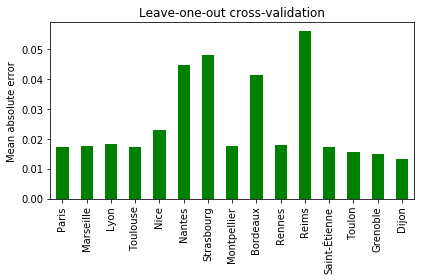

In [43]:
pd.Series(leave_one_out_mae).plot('bar', colormap="ocean")
plt.ylabel("Mean absolute error")
plt.title("Leave-one-out cross-validation")
plt.tight_layout()
plt.savefig("images/CNN_cross_validation_mae.png", dpi=600, pad_inches=0)

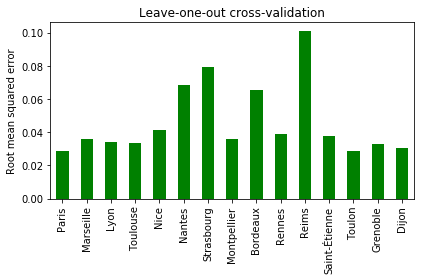

In [42]:
pd.Series(leave_one_out_rmse).plot('bar', colormap="ocean")
plt.ylabel("Root mean squared error")
plt.title("Leave-one-out cross-validation")
plt.tight_layout()
plt.savefig("images/CNN_cross_validation_rmse.png", dpi=600, pad_inches=0)

In [27]:
np.array(list(leave_one_out_mae.values())).mean()

0.02530394824058002

In [16]:
leave_one_out_mae

{'Paris': 0.01738107610875111,
 'Marseille': 0.017502561149405804,
 'Lyon': 0.018243427615534498,
 'Toulouse': 0.01731771245517625,
 'Nice': 0.02297792953593963,
 'Nantes': 0.044558154912315476,
 'Strasbourg': 0.04808881815876404,
 'Montpellier': 0.01768995426731741,
 'Bordeaux': 0.041105058640801814,
 'Rennes': 0.017795618413008685,
 'Reims': 0.05599713365592046,
 'Saint-Étienne': 0.0172584594904289,
 'Toulon': 0.015476221190023988,
 'Grenoble': 0.015067943260980264,
 'Dijon': 0.013099154754331935}

In [28]:
np.array(list(leave_one_out_rmse.values())).mean()

0.04618129435155582

In [17]:
leave_one_out_rmse

{'Paris': 0.028920892151818797,
 'Marseille': 0.03585489087888121,
 'Lyon': 0.03437186419655332,
 'Toulouse': 0.03372120273603324,
 'Nice': 0.04111300337857522,
 'Nantes': 0.06831501681882393,
 'Strasbourg': 0.07904472109468144,
 'Montpellier': 0.0358920163968285,
 'Bordeaux': 0.06555045935061252,
 'Rennes': 0.03880252820446785,
 'Reims': 0.10104466858625603,
 'Saint-Étienne': 0.037770182087151626,
 'Toulon': 0.028839587189913994,
 'Grenoble': 0.033099870734340515,
 'Dijon': 0.030378511468398973}

## Urban features
* Load stored urban features and gridded population data (see "population_osm_cities.ipynb")

In [4]:
city_sel = "Lyon"

# Validation data
Y_test, X_test, X_columns = get_Y_X_features_population_data(cities_selection=[city_sel])
# Shape
print( "Validation data shape:", Y_test.shape, X_test.shape )

# Training data
Y_train, X_train, X_columns = get_Y_X_features_population_data(cities_skip=[city_sel])
# Shape
print( "Training data shape:", Y_train.shape, X_train.shape )

Validation data shape: (10068, 25) (10068, 25, 20)
Training data shape: (86904, 25) (86904, 25, 20)


## Fully convolutional neural networks (CNNs)
* Fully convolutional architecture
* Input: Computed urban features
    * Each sample consists of 25 aggregated squares
* Usage of Rectified Linear Units activation functions
* Output layer: Soft-max activation function
    * Associates population densities to each input square

In [19]:
epochs = 100
batch_size = 32

_, input_shape_pixels, input_shape_features = X_train.shape
input_shape = (input_shape_pixels, input_shape_features)
"Input shape:", input_shape

('Input shape:', (25, 20))

In [45]:
model = Sequential()

# First layer: Input shape correspondent to X values
model.add(Conv1D(filters=10, kernel_size=1, strides=1, input_shape=input_shape  ) )
model.add(Activation('relu'))

model.add(Conv1D(filters=5, kernel_size=1, strides=1 ) )
model.add(Activation('relu'))

model.add(Conv1D(filters=1, kernel_size=1, strides=1 ) )
model.add(Activation('relu'))

# Flatten
model.add(Flatten())

# Force densities to sum 1
model.add(Activation('softmax'))

# Optimizer
#optim = optimizers.SGD(lr=0.25, decay=1e-6, momentum=0.9, nesterov=True)
optim = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile
model.compile(loss='mean_absolute_error', optimizer=optim, metrics=['mae'])

# Model shape
print( "Input:", model.input_shape, "Output:", model.output_shape )
model.summary()

Input: (None, 25, 20) Output: (None, 25)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_35 (Conv1D)           (None, 25, 10)            210       
_________________________________________________________________
activation_54 (Activation)   (None, 25, 10)            0         
_________________________________________________________________
conv1d_36 (Conv1D)           (None, 25, 5)             55        
_________________________________________________________________
activation_55 (Activation)   (None, 25, 5)             0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 25, 1)             6         
_________________________________________________________________
activation_56 (Activation)   (None, 25, 1)             0         
_________________________________________________________________
flatten_23 (Flatten)         (None,

## Train the model
* The city of Lyon is used for the model validation

In [46]:
# Fit
%time history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, Y_test))

Train on 86904 samples, validate on 10068 samples
Epoch 1/100
86904/86904 [==============================] - 13s 144us/step - loss: 0.0458 - mean_absolute_error: 0.0458 - val_loss: 0.0403 - val_mean_absolute_error: 0.0403
Epoch 2/100
86904/86904 [==============================] - 11s 128us/step - loss: 0.0417 - mean_absolute_error: 0.0417 - val_loss: 0.0359 - val_mean_absolute_error: 0.0359
Epoch 3/100
86904/86904 [==============================] - 13s 149us/step - loss: 0.0364 - mean_absolute_error: 0.0364 - val_loss: 0.0319 - val_mean_absolute_error: 0.0319
Epoch 4/100
86904/86904 [==============================] - 13s 150us/step - loss: 0.0319 - mean_absolute_error: 0.0319 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 5/100
86904/86904 [==============================] - 11s 124us/step - loss: 0.0286 - mean_absolute_error: 0.0286 - val_loss: 0.0268 - val_mean_absolute_error: 0.0268
Epoch 6/100
86904/86904 [==============================] - 14s 160us/step - loss: 0.0262 -

86904/86904 [==============================] - 13s 153us/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 96/100
86904/86904 [==============================] - 14s 166us/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 97/100
86904/86904 [==============================] - 14s 166us/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 98/100
86904/86904 [==============================] - 15s 168us/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 99/100
86904/86904 [==============================] - 14s 164us/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0183 - val_mean_absolute_error: 0.0183
Epoch 100/100
86904/86904 [==============================] - 13s 153us/step - loss: 0.0162 - mean_absolute_error: 0.0162 - val_loss: 0.0183 - val_me

## Loss values during training procedure

val_mean_absolute_error


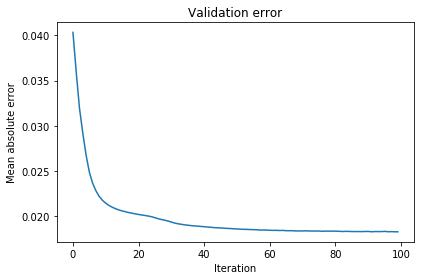

mean_absolute_error


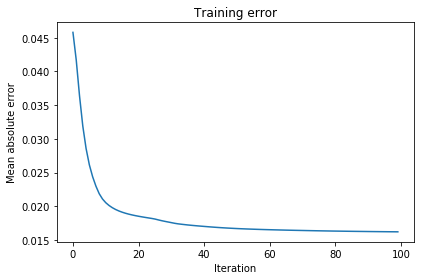

In [49]:
# Plot metrics
for k in history.history.keys():
    if ("mean_absolute_error" not in k): continue
    print(k)
    plt.plot(history.history[k])
    if ("val" in k):
        plt.title("Validation error")
    else:
        plt.title("Training error")
    plt.xlabel("Iteration")
    plt.ylabel("Mean absolute error")
    plt.tight_layout()
    plt.savefig("images/CNN_" + k + '.png', dpi=600, pad_inches=0)
    plt.show()

## Error computation
* Root mean squared error and Mean absolute error
* Compute an histogram of errors

In [50]:
MAE = []
RMSE = []

for X_, Y_ in zip(X_test, Y_test): # Validation data
    # Predict and calculate mean absolute error
    mae = model.evaluate(np.array([X_]), np.array([Y_]), verbose=0)[0]
    
    Y_pred = model.predict(np.array([X_]))[0]
    rmse = sqrt(mean_squared_error(Y_pred, Y_))

    MAE.append(mae)
    RMSE.append(rmse)
    
print( "MAE error:", np.array(MAE).mean() )
print( "RMSE error:", np.array(RMSE).mean() )

MAE error: 0.01829270565610195
RMSE error: 0.0344684860319947


### Mean absolute error

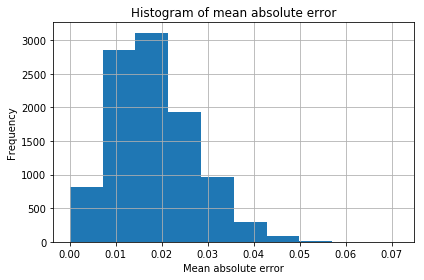

In [51]:
s_mae = pd.Series(np.array(MAE))
s_mae.hist()
plt.title("Histogram of mean absolute error")
plt.xlabel('Mean absolute error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("images/CNN_MAE.png", dpi=600, pad_inches=0)

### Root mean squared error

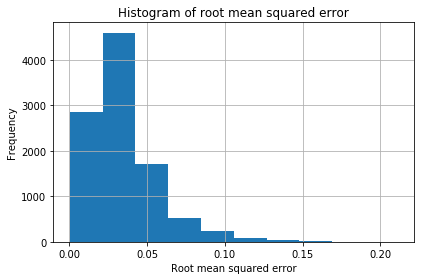

In [52]:
s_rmse = pd.Series(np.array(RMSE))
s_rmse.hist()
plt.title("Histogram of root mean squared error")
plt.xlabel('Root mean squared error')
plt.ylabel('Frequency')
plt.tight_layout()
plt.savefig("images/CNN_RMSE.png", dpi=600, pad_inches=0)